In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as keras


In [3]:
conox = "CO"

In [4]:
df = pd.read_parquet('gt2011-gt2015.parquet')  

df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,Datetime
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,2011-01-01 00:00:00
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,2011-01-01 01:10:55
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,2011-01-01 02:21:50
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,2011-01-01 03:32:45
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,2011-01-01 04:43:40
...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,2015-12-31 18:21:49
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,2015-12-31 19:33:00
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,2015-12-31 20:44:11
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,2015-12-31 21:55:22


In [5]:
df[['CO']].mean()

CO    2.372468
dtype: float64

In [6]:
df = df[['Datetime', conox]]
df.index = df['Datetime']

In [7]:
df = df.drop(df[df['Datetime']>'2013-1-1'].index)

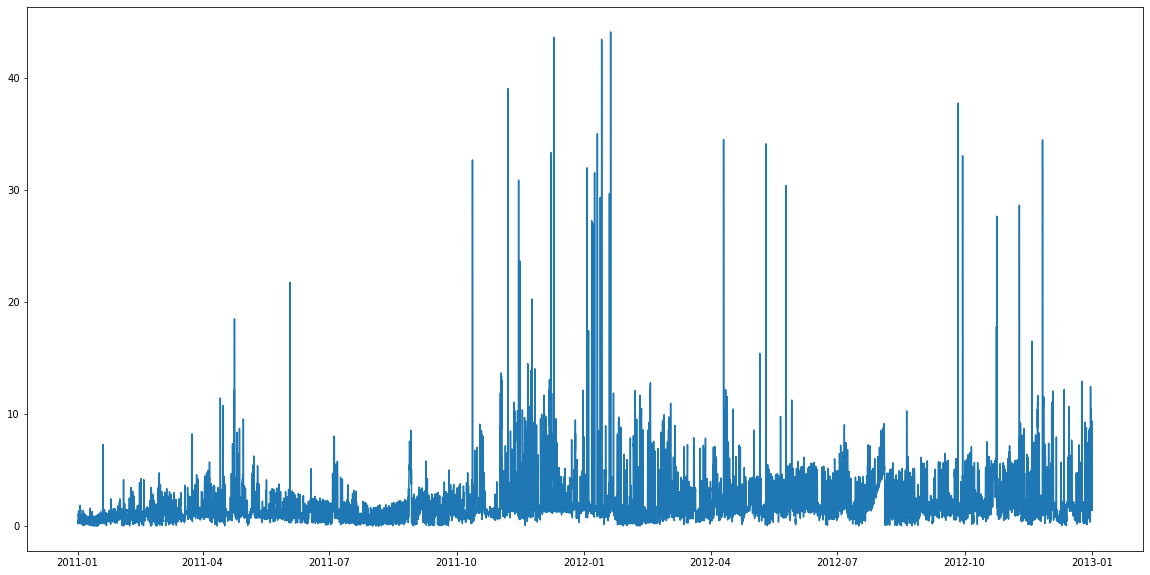

In [8]:
plt.plot(df[conox],label='CO Emission')

In [9]:
# Data Preparation
data = pd.DataFrame(index=range(0,len(df)),columns=['Datetime',conox])
for i in range(0,len(data)):
    data["Datetime"][i]=df['Datetime'][i]
    data[conox][i]=df[conox][i]
data.head()

,Datetime,CO
0,2011-01-01 00:00:00,0.32663
1,2011-01-01 01:10:55,0.44784
2,2011-01-01 02:21:50,0.45144
3,2011-01-01 03:32:45,0.23107
4,2011-01-01 04:43:40,0.26747


In [10]:
#first week of 2012: 7411:7557
scaler=MinMaxScaler(feature_range=(0,1))
data.index=data.Datetime
data.drop('Datetime',axis=1,inplace=True)
final_data = data.values

In [11]:
train_data=data[data.index<'2012-1-1'].values
valid_data=data[data.index>'2012-1-1'].values
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(180,len(train_data)):
    x_train_data.append(scaled_data[i-180:i,0])
    y_train_data.append(scaled_data[i,0])

In [12]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-180:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [13]:
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)

In [14]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(180,model_data.shape[0]):
    X_test.append(model_data[i-180:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

7231/7231 - 442s - loss: 0.0014 - 442s/epoch - 61ms/step


In [15]:
predicted_CO=lstm_model.predict(X_test)
predicted_CO=scaler.inverse_transform(predicted_CO)

In [16]:
valid_data

array([[3.2363],
       [3.2012],
       [3.1923],
       ...,
       [1.3963],
       [8.0107],
       [9.3472]], dtype=object)

C:\Users\gilbaram\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\gilbaram\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


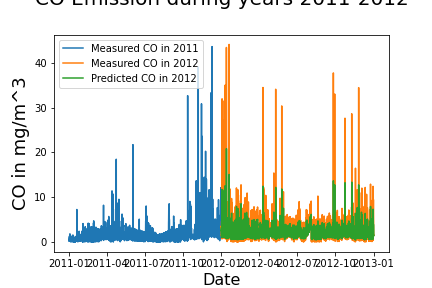

In [18]:
%matplotlib widget
# train_data = df[df['Datetime'].dt.year.isin([2011, 2012, 2013])]
train_data=data[data.index<'2012-1-1']
valid_data=data[data.index>'2012-1-1']
valid_data.loc[:,'Predictions']=predicted_CO
ax = plt.axes()


plt.ylabel('CO in mg/m^3', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.plot(train_data[conox])

plt.plot(valid_data[[conox,'Predictions']])
plt.title("CO Emission during years 2011-2012", fontsize = 20, pad = 30)
ax.legend(['Measured CO in 2011','Measured CO in 2012','Predicted CO in 2012'])

In [20]:
conox = "NOX"
df = pd.read_parquet('gt2011-gt2015.parquet')
df = df[['Datetime', conox]]
df.index = df['Datetime']

In [21]:
df[df['Datetime']>'2013-1-1']

,Datetime,NOX
Datetime,,
2013-01-01 01:13:29,2013-01-01 01:13:29,104.290
2013-01-01 02:26:58,2013-01-01 02:26:58,103.470
2013-01-01 03:40:27,2013-01-01 03:40:27,108.810
2013-01-01 04:53:56,2013-01-01 04:53:56,100.020
2013-01-01 06:07:25,2013-01-01 06:07:25,96.442
...,...,...
2015-12-31 18:21:49,2015-12-31 18:21:49,89.172
2015-12-31 19:33:00,2015-12-31 19:33:00,88.849
2015-12-31 20:44:11,2015-12-31 20:44:11,96.147


In [22]:
df = df.drop(df[df['Datetime']>'2013-1-1'].index)
plt.plot(df[conox],label='NOx Emission')

In [23]:
# Data Preparation
data = pd.DataFrame(index=range(0,len(df)),columns=['Datetime',conox])
for i in range(0,len(data)):
    data["Datetime"][i]=df['Datetime'][i]
    data[conox][i]=df[conox][i]
data.head()

,Datetime,NOX
0,2011-01-01 00:00:00,81.952
1,2011-01-01 01:10:55,82.377
2,2011-01-01 02:21:50,83.776
3,2011-01-01 03:32:45,82.505
4,2011-01-01 04:43:40,82.028


In [24]:
scaler=MinMaxScaler(feature_range=(0,1))
data.index=data.Datetime
data.drop('Datetime',axis=1,inplace=True)
final_data = data.values

In [25]:
train_data=data[data.index<'2012-1-1'].values
valid_data=data[data.index>'2012-1-1'].values
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(120,len(train_data)):
    x_train_data.append(scaled_data[i-120:i,0])
    y_train_data.append(scaled_data[i,0])

In [26]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-120:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [27]:
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)

In [28]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(120,model_data.shape[0]):
    X_test.append(model_data[i-120:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

7291/7291 - 370s - loss: 0.0045 - 370s/epoch - 51ms/step


In [29]:
predicted_NOx=lstm_model.predict(X_test)
predicted_NOx=scaler.inverse_transform(predicted_NOx)

C:\Users\gilbaram\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\gilbaram\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


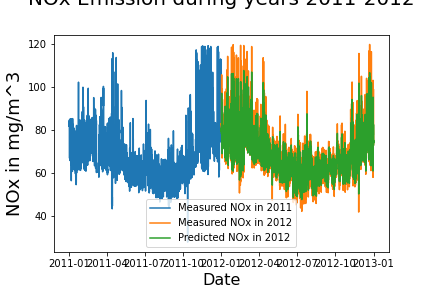

In [30]:
%matplotlib widget
# train_data = df[df['Datetime'].dt.year.isin([2011, 2012, 2013])]
train_data=data[data.index<'2012-1-1']
valid_data=data[data.index>'2012-1-1']
valid_data.loc[:,'Predictions']=predicted_NOx
ax = plt.axes()


plt.ylabel('NOx in mg/m^3', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.plot(train_data[conox])

plt.plot(valid_data[[conox,'Predictions']])
plt.title("NOx Emission during years 2011-2012", fontsize = 20, pad = 30)
ax.legend(['Measured NOx in 2011','Measured NOx in 2012','Predicted NOx in 2012'])